In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sopt.examples.utils import getSampleObj
from sopt.optimizers.tensorflow import Curveball, LMA

In [2]:
%load_ext autoreload
%autoreload 2

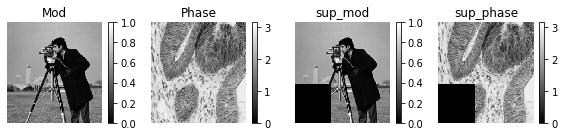

In [3]:
image = getSampleObj(256, phase_range=np.pi)
ft_mod = np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(image), norm='ortho')))

var_shape = 100
sample_support = image.copy()
sample_support[:var_shape, :var_shape] = 0

plt.figure(figsize=[8,2])
figs = { 'Mod':np.abs(image), 'Phase':np.angle(image), 
        'sup_mod':np.abs(sample_support), 'sup_phase': np.angle(sample_support)}
for i, (key, val) in enumerate(figs.items()):
    plt.subplot(1,4,i+1)
    plt.pcolormesh(val, cmap='gray')
    plt.colorbar()
    plt.title(key)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [4]:
init_weights = np.ones(2 * var_shape * var_shape)
support_shape = sample_support.shape[0]
var_shape, support_shape

(100, 256)

In [7]:
tf.reset_default_graph()
tf_var = tf.get_variable('var', dtype=tf.float32, shape=[2 * var_shape**2], initializer=tf.ones_initializer)
tf_support = tf.constant(sample_support, dtype=tf.complex64, name='support')
tf_diffraction_mod = tf.constant(np.fft.fftshift(ft_mod).flatten(), dtype=tf.float32, name='diffractions')

def get_var_and_support(var):
    tf_var_reshaped = tf.reshape(var, [2, var_shape, var_shape])
    tf_var_cmplx = tf.complex(tf_var_reshaped[0], tf_var_reshaped[1])
    tf_var_padded = tf.pad(tf_var_cmplx, [[0,support_shape - var_shape], [0, support_shape - var_shape]])
    tf_var_and_support = tf_var_padded + tf_support
    return tf_var_and_support

def predictions_fn(var):
    tf_var_and_support = get_var_and_support(var)
    tf_fft_mod = tf.abs(tf.fft2d(tf_var_and_support)) / support_shape
    return tf.reshape(tf_fft_mod, [-1])

def loss_fn(predictions):
    return 0.5 * tf.reduce_sum((predictions - tf_diffraction_mod)**2)


loss_fn_tensor = loss_fn(predictions_fn(tf_var))
var_and_support = get_var_and_support(tf_var)

lma_opt = LMA(tf_var, predictions_fn, loss_fn, name='opt1', hessian_fn=lambda x: 1.0, assert_tolerances=False)
min_op = lma_opt.minimize()  

In [8]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [9]:
for i in range(100):
    _, lossval = session.run([min_op, loss_fn_tensor])
    if i % 5 == 0: print(lossval)#, lossval2)

3714.0376
0.19758561
8.770578e-10
8.770578e-10
8.770578e-10
8.770578e-10
8.770578e-10
8.770578e-10
8.770578e-10
8.770578e-10
8.770578e-10
8.770578e-10
8.770578e-10
8.770578e-10
8.770578e-10
8.770578e-10
8.770578e-10
8.770578e-10
8.770578e-10
8.770578e-10


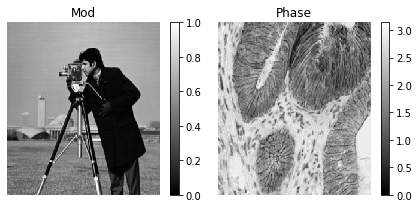

In [10]:
out = session.run(var_and_support)
plt.figure(figsize=[6,3])
figs = { 'Mod':np.abs(out), 'Phase':np.angle(out)}
for i, (key, val) in enumerate(figs.items()):
    plt.subplot(1,2,i+1)
    plt.pcolormesh(val, cmap='gray')
    plt.colorbar()
    plt.title(key)
    plt.axis('off')
plt.tight_layout()
plt.show()